In [10]:
# CELL 1 - Kütüphaneler ve Veri Yükleme
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Stil ayarı (sunumda güzel dursun)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Kütüphaneler yüklendi.\n")

# Veri yükleme
df = pd.read_csv('final_proje_dataset_CLEAN.csv')

print(f"Veri seti başarıyla yüklendi!")
print(f"Toplam satır: {df.shape[0]:,}")
print(f"Toplam sütun: {df.shape[1]}")
df.head()

Kütüphaneler yüklendi.

Veri seti başarıyla yüklendi!
Toplam satır: 11,060
Toplam sütun: 180


,date,/m/05p0rrx,/m/0108bn2x,/g/11tskkw5c9,/g/11sfdkgmfn,/g/11hcz1r4wl,/g/11pcs9ny8w,/g/11bw1zmnts,/m/0273t5w,/g/1234z6p9,...,/g/11jt20l831,/g/11h7_q3l6z,/g/11jp_j0m6d,/m/01h7lh,/m/0rfgxy2,/g/11ww08lq0j,/g/11vhqc7hb1,/m/02xz2,/m/0179v6,Country
0,2021-12-26,37,14,0,0,2,1,0,53,0,...,0,2,0,30,32,0.0,0.0,17.0,0.0,US
1,2022-01-02,47,18,0,0,2,2,0,70,0,...,0,4,0,27,19,0.0,0.0,16.0,0.0,US
2,2022-01-09,43,18,0,0,2,1,0,71,0,...,0,4,0,27,18,0.0,0.0,15.0,0.0,US
3,2022-01-16,49,18,0,0,2,1,0,70,0,...,0,4,0,30,13,0.0,0.0,13.0,0.0,US
4,2022-01-23,63,19,0,0,2,1,0,74,0,...,0,4,0,39,15,0.0,0.0,14.0,0.0,US


In [11]:
# CELL 2 - Temel Bilgiler
print("=== VERİ SETİ ÖZETİ ===\n")

# 1) Kaç tane feature (search term) var?
feature_columns = [col for col in df.columns if col not in ['date', 'Country']]
n_features = len(feature_columns)

print(f"1. Toplam feature (search term) sayısı: {n_features}")

# 2) Kaç farklı ülke var?
n_countries = df['Country'].nunique()

print(f"2. Toplam farklı ülke sayısı: {n_countries}")
print(f"   Ülkeler: {sorted(df['Country'].unique())}")

# 3) Tarih aralığı
df['date'] = pd.to_datetime(df['date'])
min_date = df['date'].min()
max_date = df['date'].max()
n_weeks = df['date'].nunique()

print(f"3. Zaman aralığı:")
print(f"   İlk tarih: {min_date.date()}")
print(f"   Son tarih: {max_date.date()}")
print(f"   Toplam hafta sayısı: {n_weeks}")
print(f"   Beklenen süre: ~4 yıl ({(max_date - min_date).days // 7 + 1} hafta)")

# Her ülke için ilk ve son tarih kontrolü
country_date_range = df.groupby('Country')['date'].agg(['min', 'max']).reset_index()
country_date_range['min'] = pd.to_datetime(country_date_range['min'])
country_date_range['max'] = pd.to_datetime(country_date_range['max'])
country_date_range['eksik_hafta_yok_mu'] = (country_date_range['min'] == min_date) & (country_date_range['max'] == max_date)

print(f"\n   Tüm ülkelerde tam veri var mı? {'EVET' if country_date_range['eksik_hafta_yok_mu'].all() else 'HAYIR'}")
if not country_date_range['eksik_hafta_yok_mu'].all():
    print("   Eksik veri olan ülkeler:")
    print(country_date_range[~country_date_range['eksik_hafta_yok_mu']][['Country', 'min', 'max']])

=== VERİ SETİ ÖZETİ ===

1. Toplam feature (search term) sayısı: 178
2. Toplam farklı ülke sayısı: 70
   Ülkeler: ['AE', 'AR', 'AT', 'AU', 'BD', 'BE', 'BG', 'BO', 'BR', 'CA', 'CH', 'CL', 'CO', 'CZ', 'DE', 'DK', 'EC', 'EE', 'EG', 'ES', 'FI', 'FR', 'GB', 'GH', 'GR', 'HK', 'HR', 'HU', 'ID', 'IE', 'IL', 'IN', 'IT', 'JP', 'KE', 'KR', 'LK', 'LT', 'LV', 'MA', 'MM', 'MX', 'MY', 'NG', 'NL', 'NO', 'NZ', 'PE', 'PH', 'PK', 'PL', 'PT', 'RO', 'RS', 'RU', 'SA', 'SE', 'SG', 'SI', 'SK', 'TH', 'TN', 'TR', 'TW', 'UA', 'US', 'UY', 'VE', 'VN', 'ZA']
3. Zaman aralığı:
   İlk tarih: 2021-12-26
   Son tarih: 2024-12-29
   Toplam hafta sayısı: 158
   Beklenen süre: ~4 yıl (158 hafta)

   Tüm ülkelerde tam veri var mı? EVET


In [12]:
# CELL 3 - Her Feature İçin Ülke Kapsamı (skor >10 olan ülkeler)
print("4. Her feature'ın kaç farklı ülkede ilgi gördüğü (skor > 10 olan ülke sayısı)\n")

# Her feature için skor >10 olan distinct ülke sayısını hesapla
feature_coverage = []

for col in feature_columns:
    # Bu feature'da skor >10 olan ülkeler
    active_countries = df[df[col] > 10]['Country'].nunique()
    feature_coverage.append({
        'feature': col,
        'active_country_count': active_countries
    })

coverage_df = pd.DataFrame(feature_coverage)
coverage_df = coverage_df.sort_values('active_country_count', ascending=False).reset_index(drop=True)

print(f"   Global ilgi gören feature'lar (60+ ülkede >10 skor): {len(coverage_df[coverage_df['active_country_count'] >= 50])}")
print(f"   Orta ilgi (20-49 ülke): {len(coverage_df[(coverage_df['active_country_count'] >= 20) & (coverage_df['active_country_count'] < 60)])}")
print(f"   Niş / az ilgi (<20 ülke): {len(coverage_df[coverage_df['active_country_count'] < 20])}")
print(f"   Hiç ilgi görmeyen (0 ülke): {len(coverage_df[coverage_df['active_country_count'] == 0])}")

# En iyi ve en kötü 10 feature
print("\n   En çok ilgi gören 10 feature:")
print(coverage_df.head(10)[['feature', 'active_country_count']].to_string(index=False))

print("\n   En az ilgi gören 10 feature:")
print(coverage_df.tail(10)[['feature', 'active_country_count']].to_string(index=False))

4. Her feature'ın kaç farklı ülkede ilgi gördüğü (skor > 10 olan ülke sayısı)

   Global ilgi gören feature'lar (60+ ülkede >10 skor): 65
   Orta ilgi (20-49 ülke): 54
   Niş / az ilgi (<20 ülke): 71
   Hiç ilgi görmeyen (0 ülke): 14

   En çok ilgi gören 10 feature:
      feature  active_country_count
   /m/05p0rrx                    70
     /m/09jx2                    70
/g/11bc6pz4wc                    70
   /m/0_t06w0                    70
 /g/1ymzxwzdh                    70
   /m/0h5x4j3                    70
 /g/1hd_npv62                    70
     /m/05k97                    70
     /m/0j6v7                    70
/g/11bc6n2sw6                    70

   En az ilgi gören 10 feature:
      feature  active_country_count
/g/11lyxggfjt                     0
/g/11cknh9qp1                     0
    /m/06_7xx                     0
/g/11twnws_cc                     0
  /g/121hrbch                     0
/g/11h79tp_8r                     0
/g/11g6qlbmr4                     0
/g/11sq21scf3  

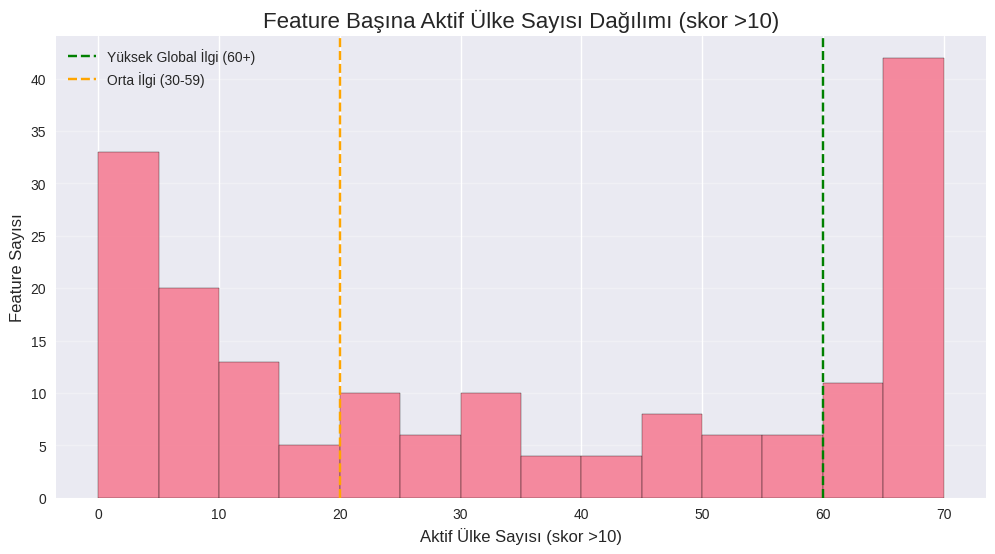

Bu grafik presentation'da harika durur: Sağ tarafa doğru ne kadar çok feature varsa o kadar global trend yakalamışız demektir.


In [13]:
# CELL 4 - Görselleştirme: Feature Kapsamı Dağılımı
plt.figure(figsize=(12, 6))
plt.hist(coverage_df['active_country_count'], bins=range(0, 71, 5), edgecolor='black', alpha=0.8)
plt.title('Feature Başına Aktif Ülke Sayısı Dağılımı (skor >10)', fontsize=16)
plt.xlabel('Aktif Ülke Sayısı (skor >10)', fontsize=12)
plt.ylabel('Feature Sayısı', fontsize=12)
plt.axvline(60, color='green', linestyle='--', label='Yüksek Global İlgi (60+)')
plt.axvline(20, color='orange', linestyle='--', label='Orta İlgi (30-59)')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

print("Bu grafik presentation'da harika durur: Sağ tarafa doğru ne kadar çok feature varsa o kadar global trend yakalamışız demektir.")

In [14]:
# CELL 5 - Feature Temizleme: 20'den az ülkede aktif olanları çıkar
print("=== FEATURE TEMİZLEME (skor >10 olan ülke sayısı >= 20) ===\n")

# Daha önce hesapladığımız coverage_df'yi kullanıyoruz (CELL 3'te var)
# Eğer CELL 3 çalışmadıysa tekrar hesapla
if 'coverage_df' not in locals():
    feature_columns = [col for col in df.columns if col not in ['date', 'Country']]
    feature_coverage = []
    for col in feature_columns:
        active_countries = df[df[col] > 10]['Country'].nunique()
        feature_coverage.append({'feature': col, 'active_country_count': active_countries})
    coverage_df = pd.DataFrame(feature_coverage).sort_values('active_country_count', ascending=False).reset_index(drop=True)

# Threshold: 20'den az ülkede aktif olanları çıkar
threshold = 20
low_interest_features = coverage_df[coverage_df['active_country_count'] < threshold]['feature'].tolist()
high_interest_features = coverage_df[coverage_df['active_country_count'] >= threshold]['feature'].tolist()

print(f"Threshold: >= {threshold} ülkede skor >10")
print(f"Temizlenmiş feature sayısı: {len(high_interest_features)} (önceki: {len(feature_columns)})")
print(f"Çıkarılan feature sayısı: {len(low_interest_features)}")
print(f"Kalan feature oranı: %{(len(high_interest_features) / len(feature_columns) * 100):.1f}")

# Temizlenmiş dataframe oluştur
df_cleaned = df[['date', 'Country'] + high_interest_features].copy()

print(f"\nYeni dataframe: df_cleaned ({df_cleaned.shape[0]:,} satır, {df_cleaned.shape[1]} sütun)")

# Çıkarılan feature'ları sunumda göstermek istersen
print(f"\nÇıkarılan {len(low_interest_features)} feature (örnek 10 tane):")
print(low_interest_features[:10])

# Opsiyonel: Temizlenmiş veriyi kaydet (ileride clustering için)
df_cleaned.to_csv('final_proje_dataset_CLEANED_features.csv', index=False)
print("\nTemizlenmiş veri kaydedildi: final_proje_dataset_CLEANED_features.csv")

=== FEATURE TEMİZLEME (skor >10 olan ülke sayısı >= 20) ===

Threshold: >= 20 ülkede skor >10
Temizlenmiş feature sayısı: 107 (önceki: 178)
Çıkarılan feature sayısı: 71
Kalan feature oranı: %60.1

Yeni dataframe: df_cleaned (11,060 satır, 109 sütun)

Çıkarılan 71 feature (örnek 10 tane):
['/m/02wpj1', '/g/11mcz640x1', '/g/11y97_pvw8', '/g/11cm999bwp', '/m/0br5fz', '/m/03cvdr8', '/g/11xdtrjhz', '/g/11q4gczjq8', '/m/0n5462l', '/g/11nyxr7hxv']

Temizlenmiş veri kaydedildi: final_proje_dataset_CLEANED_features.csv


In [15]:
# CELL 6 - Güncellenmiş Sunum Tablosu (Temizleme Sonrası)
print("=== SUNUM İÇİN GÜNCELLENMİŞ ÖZET TABLO ===\n")

updated_summary = pd.DataFrame({
    'Özellik': [
        'Toplam Feature Sayısı (ham)',
        'Kalan Feature Sayısı (temizlenmiş)',
        'Çıkarılan Feature Sayısı',
        'Toplam Ülke Sayısı',
        'Zaman Aralığı',
        'Toplam Hafta',
        'Yüksek Global Feature (60+ ülke)',
        'Orta-Yüksek Global Feature (20-59 ülke)',
        'Niş Feature (çıkarılan, <20 ülke)'
    ],
    'Değer': [
        len(feature_columns),
        len(high_interest_features),
        len(low_interest_features),
        n_countries,
        f"{min_date.date()} → {max_date.date()}",
        n_weeks,
        len(coverage_df[coverage_df['active_country_count'] >= 60]),
        len(coverage_df[(coverage_df['active_country_count'] >= 20) & (coverage_df['active_country_count'] < 60)]),
        len(low_interest_features)
    ]
})

print(updated_summary.to_string(index=False))

=== SUNUM İÇİN GÜNCELLENMİŞ ÖZET TABLO ===

                                Özellik                   Değer
            Toplam Feature Sayısı (ham)                     178
     Kalan Feature Sayısı (temizlenmiş)                     107
               Çıkarılan Feature Sayısı                      71
                     Toplam Ülke Sayısı                      70
                          Zaman Aralığı 2021-12-26 → 2024-12-29
                           Toplam Hafta                     158
       Yüksek Global Feature (60+ ülke)                      53
Orta-Yüksek Global Feature (20-59 ülke)                      54
      Niş Feature (çıkarılan, <20 ülke)                      71
